In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.templates import BasicEntanglerLayers
import tqdm
import matplotlib.pyplot as plt

from sklearn.datasets import  make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
import math


In [2]:
dev = qml.device("default.qubit", wires=4)

In [3]:
################################
#    Model  Rot‒CNOT‒1,1,1‒CNOT
################################

@qml.qnode(dev)
def circuit_Rot_CNOT_1_1_1_CNOT(weights, inputs, n_wires):
    for i in range(n_angle_encoding):
        qml.AngleEmbedding(inputs[i*n_wires:i*n_wires+n_wires], wires=range(n_wires))    
        qml.StronglyEntanglingLayers(weights[i], wires = range (n_wires), ranges=[1,1,1])   

    #  added CNOT  before measurementmtn
    for i in range(n_wires-1):
         qml.CNOT(wires=[ (i + 1) % n_wires, 0])

    return qml.expval(qml.PauliZ(0))

In [4]:
################################
#    Model  Rot‒CNOT‒1,1,1
################################

@qml.qnode(dev)
def circuit_Rot_CNOT_1_1_1(weights, inputs, n_wires):
    for i in range(n_angle_encoding):
        qml.AngleEmbedding(inputs[i*n_wires:i*n_wires+n_wires], wires=range(n_wires))   
        qml.StronglyEntanglingLayers(weights[i], wires = range (n_wires), ranges=[1,1,1])   

    return qml.expval(qml.PauliZ(0))

In [5]:
################################
#    Model  Rot‒CNOT‒1,2,3
################################

@qml.qnode(dev)
def circuit_Rot_CNOT_1_2_3(weights, inputs, n_wires):
    for i in range(n_angle_encoding):
        qml.AngleEmbedding(inputs[i*n_wires:i*n_wires+n_wires], wires=range(n_wires))    
        qml.StronglyEntanglingLayers(weights[i], wires = range (n_wires), ranges=[1,2,3])    

    return qml.expval(qml.PauliZ(0))



In [6]:
################################
#    Model  RX‒CNOT‒1,1,1
################################
  
def layer_with_RX(layer_weights, n_wires):
    for wire in range(n_wires):
        qml.RX(*layer_weights[wire] , wires=wire)
        
    for i in range(n_wires):
        qml.CNOT(wires=[i, (i + 1) % n_wires])

@qml.qnode(dev)
def circuit_RX_CNOT_1_1_1 (weights, inputs, n_wires):
    for i in range(n_angle_encoding):
        qml.AngleEmbedding(inputs[i*n_wires:i*n_wires+n_wires], wires=range(n_wires))   
        for layer in weights[i]:       #per layer 
            layer_with_RX(layer, n_wires)

    return qml.expval(qml.PauliZ(0))

In [7]:
################################
#    Model  RY‒CNOT‒1,1,1
################################
    
def layer_with_RY(layer_weights, n_wires):
    for wire in range(n_wires):
        qml.RY(*layer_weights[wire] , wires=wire)
        
    for i in range(n_wires):
        qml.CNOT(wires=[i, (i + 1) % n_wires])

@qml.qnode(dev)
def circuit_RY_CNOT_1_1_1(weights, inputs, n_wires):
    for i in range(n_angle_encoding):
        qml.AngleEmbedding(inputs[i*n_wires:i*n_wires+n_wires], wires=range(n_wires))    #rotation='X'
        for layer in weights[i]:       #per layer 
            layer_with_RY(layer, n_wires)

    return qml.expval(qml.PauliZ(0))

In [8]:
#################################
# return 
# circuit_Rot_CNOT_1_1_1_CNOT
# circuit_Rot_CNOT_1_1_1
# circuit_Rot_CNOT_1_2_3
# circuit_RX_CNOT_1_1_1
# circuit_RY_CNOT_1_1_1
def variational_regression(var, features, n_wires):
    return circuit_Rot_CNOT_1_1_1_CNOT(var, features, n_wires)

In [9]:
################################
#  Define loss function (MSE)
################################
def mean_squared_loss(labels, predictions):
     return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [10]:
################################
#  Define cost function
################################
def cost(weights, features, labels, n_wires):
    predictions = [variational_regression(weights, f, n_wires) for f in features] 
    cost = mean_squared_loss(labels, predictions)
    return cost 

# ----------------------------------------- read data 



# ------------------------- 1. make regression data 

In [11]:
###################################
#  Artificial dataset
###################################
from sklearn.datasets import make_regression
X, y, coef_ = make_regression(n_samples=2000, n_features=4, shuffle=False,  n_targets=1, bias=0.0, coef=True, random_state=42)


# ------------------------- 2.  Dataset  Folds5x2_pp
https://www.kaggle.com/datasets/gova26/airpressure?resource=download


In [ ]:
###################################
#  Real dataset
###################################
df = pd.read_csv('../data/Folds5x2_pp.csv')

In [10]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [ ]:
y= df.iloc[:,-1].to_numpy()
tmp = pd.DataFrame([df.AT, df.V, df.AP, df.PE]).transpose()
X= tmp.to_numpy()

In [12]:
print(X)

[[   8.34   40.77 1010.84  480.48]
 [  23.64   58.49 1011.4   445.75]
 [  29.74   56.9  1007.15  438.76]
 ...
 [  15.99   43.34 1014.2   465.96]
 [  17.65   59.87 1018.58  450.93]
 [  23.68   51.3  1011.86  451.67]]


# ------------------------- end read data 



In [17]:

X_frame = pd.DataFrame(X)
X_frame.head()


,0,1,2,3
0,1.806837,1.459490,1.910980,2.150090
1,1.451632,1.419082,2.368719,1.838350
2,1.337265,1.746440,1.364998,1.329578
3,1.683027,0.711366,0.745114,1.289741
4,1.073190,1.650212,1.146524,0.939045


[115.53477428 164.79614681 -37.39878161 ... 139.12340365  70.28556323
 197.29191517]
(2000,)
<class 'numpy.ndarray'>
(2000, 1)
[[115.53477428]
 [164.79614681]
 [-37.39878161]
 ...
 [139.12340365]
 [ 70.28556323]
 [197.29191517]]


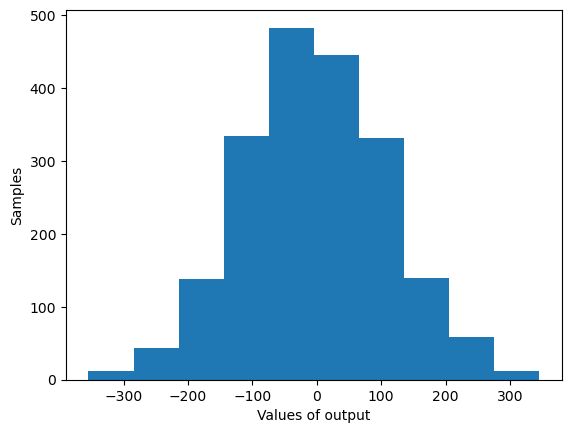

Max in samples is 345.63751991866184 
Min in samples is -354.7419202607969 
Standard Deviation of sample is 112.09724710459734 
Mean in samples is -3.049518405507873 


In [18]:
print(y)
print(y.shape)
print(type(y))
y_plot= y.reshape(-1,1)
print(y_plot.shape)
print(y_plot)
from matplotlib import pyplot
import statistics

pyplot.hist(y_plot[:, 0]) 

pyplot.ylabel("Samples")
pyplot.xlabel("Values of output")
#pyplot.savefig("Samples_2000.png")

pyplot.show()

print("Max in samples is % s "  % (y_plot[:, 0].max()))
print("Min in samples is % s " % (y_plot[:, 0].min()))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(y_plot[:, 0])))
print("Mean in samples is % s " % (y_plot[:, 0].mean()))

In [19]:
from sklearn.preprocessing import MinMaxScaler

fr=(0, math.pi)
X_frame[0] = MinMaxScaler(feature_range=fr).fit_transform(X_frame[[0]])
X_frame[1] = MinMaxScaler(feature_range=fr).fit_transform(X_frame[[1]])
X_frame[2] = MinMaxScaler(feature_range=fr).fit_transform(X_frame[[2]])
X_frame[3] = MinMaxScaler(feature_range=fr).fit_transform(X_frame[[3]])

In [20]:
X_frame.head()

,0,1,2,3
0,1.806837,1.459490,1.910980,2.150090
1,1.451632,1.419082,2.368719,1.838350
2,1.337265,1.746440,1.364998,1.329578
3,1.683027,0.711366,0.745114,1.289741
4,1.073190,1.650212,1.146524,0.939045


In [21]:
X = X_frame.to_numpy()
print(X)


[[1.80683746 1.45949022 1.91098012 2.15008986]
 [1.45163182 1.41908235 2.3687185  1.83835042]
 [1.33726452 1.74644023 1.3649976  1.32957794]
 ...
 [1.72326594 1.76245948 2.18691429 1.51170626]
 [2.36197547 1.90047336 1.24508858 2.43345682]
 [1.72435278 1.1657815  2.4049338  2.37896475]]


In [22]:
print(X.max())
print(X.min())

3.141592653589793
0.0


# -------------------------------

In [23]:

#scale [0,1]
y = (MinMaxScaler(feature_range=(0, 1)).fit_transform(y.reshape(-1,1))).reshape(1,-1)
y = y[0,:] 


encoding = ['amplitude', 'dense_angle', 'angle'][2]

print('encoding:', encoding)

n_qubits_min = 4
n_qubits=0
n_angle_encoding=1
pad_zeros = 0

n_samples  = X.shape[0] 
n_features = X.shape[1]

if encoding=='amplitude':
    n_qubits   = math.ceil(math.log2(n_features))
    pad_zeros = 2 ** n_qubits - n_features
elif encoding=='dense_angle':
    n_qubits = min(n_qubits_min , math.ceil(n_features/2)) # max number of device is 9
    if n_qubits==n_qubits_min: # find iterations
        n_angle_encoding = math.ceil((n_features/2)/n_qubits)
elif encoding=='angle':    
    n_qubits = min(n_qubits_min , math.ceil(n_features)) # # max number of device is 9
    if (n_qubits==n_qubits_min): # find iterations
        n_angle_encoding = math.ceil(n_features/n_qubits)
else:
    print('Νο quantum encoding')


print('n_features' , n_features)
print('n_qubits', n_qubits)
print('n_angle_encoding-blocks', n_angle_encoding)
print('pad_zeros', pad_zeros)


if pad_zeros < 0:
    print('Parameters pad_zeros can not have negative values')
else:
    X_pad = np.pad(X, [(0, 0), (0, pad_zeros)], mode='constant')

if encoding=='amplitude':
    sum_row = np.sum(X_pad ** 2, axis=1)
    normalization = np.sqrt(sum_row)
    X_norm = (X_pad.T / normalization).T
elif encoding=='dense_angle':
    X_norm = X_pad
else:
    X_norm = X_pad



encoding: angle
n_features 4
n_qubits 4
n_angle_encoding-blocks 1
pad_zeros 0


In [24]:
train_size=0.75
X = X_norm
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True)

In [25]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import  pearsonr
from lifelines.utils import concordance_index
import pandas as pd
from pathlib import Path
from datetime import datetime
import time

n_epochs = 30
batch_size = 10 
n_layers = 3
n_angle_rotations = 3 # Rot Gate 3 rotations
                      # RX, RY gate 1 rotation 
data_plot = 17  
if encoding=='amplitude':
    weights_init = 0.01 * np.random.randn( n_layers, n_qubits, n_angle_rotations, requires_grad=True)
elif encoding=='dense_angle':
    weights_init = 0.01 * np.random.randn(n_angle_encoding, n_layers, n_qubits, n_angle_rotations, requires_grad=True) 
elif encoding=='angle':
    weights_init = 0.01 * np.random.randn(n_angle_encoding, n_layers, n_qubits, n_angle_rotations, requires_grad=True) 
else:
    weights_init = 0.01 * np.random.randn(  n_layers, n_qubits, n_angle_rotations, requires_grad=True)
     
opt = qml.GradientDescentOptimizer() 
batch_start = np.arange(0, len(X_train), batch_size)
iterations = np.empty((n_epochs,data_plot))
start_time = time.time()

# train the VQR
weights_ = weights_init
for epoch in range(n_epochs):
    cst_avg = 0
    batches = 0
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            X_train_batch = X_train[start:start+batch_size]
            y_train_batch = y_train[start:start+batch_size]
            
            weights_, cst = opt.step_and_cost(lambda v: cost(v, X_train_batch, y_train_batch, n_qubits), weights_)
                            
            cst_avg += cst 
            batches +=1
            bar.set_postfix_str(cst)
    
    predictions_train = [variational_regression(weights_, f, n_qubits) for f in X_train]
    predictions_test = [variational_regression(weights_, f, n_qubits) for f in X_test]
    mse_train = mean_squared_error(y_train, predictions_train)
    mse_test  = mean_squared_error(y_test, predictions_test)
    r2_train =  r2_score(y_train, predictions_train)
    r2_test  =  r2_score(y_test, predictions_test)
    adjusted_r2_train = 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)  # Adjusted R-Squared
    adjusted_r2_test  = 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)  # Adjusted R-Squared
    
    # first we do the validation and then we take the test measurements
    iterations[epoch,0] = epoch + 1
    iterations[epoch,1] = mse_train
    iterations[epoch,2] = mse_test
    iterations[epoch,3] = np.sqrt(mse_train)
    iterations[epoch,4] = np.sqrt(mse_test)
    iterations[epoch,5] = r2_train
    iterations[epoch,6] = r2_test
    iterations[epoch,7] = adjusted_r2_train
    iterations[epoch,8] = adjusted_r2_test
    iterations[epoch,9] = mean_absolute_error(y_train, predictions_train)
    iterations[epoch,10] = mean_absolute_error(y_test, predictions_test)
    iterations[epoch,11], iterations[epoch,12]  = pearsonr(y_train, predictions_train) #second value is p value
    iterations[epoch,13], iterations[epoch,14]  = pearsonr(y_test, predictions_test) #second value is p value
    iterations[epoch,15] = concordance_index(y_train, predictions_train)
    iterations[epoch,16] = concordance_index(y_test, predictions_test)
    print(
        "Epoch: {:3d}  | Total Cost {:0.7f} | Batches {:0.7f} | AvgCost {:0.7f} | Cost_ {:0.7f} |MSE train: {:0.7f} | MSE validation: {:0.7f} "
           "".format(epoch + 1, cst_avg  , batches, cst_avg/batches, cst , mse_train, mse_test)
    )

print("Samples: {:5d}  | Features {:5d} | Epochs  {:5d} | Batch size {:5d} | Time {:10f} sec"
      "".format(X.shape[0], X.shape[1], n_epochs, batch_size, time.time() - start_time ))
print("--- %s seconds ---" % (time.time() - start_time))
path = Path(f'pennylane_export/{datetime.now().strftime("%m%d%H")}.csv')
iterations_df = pd.DataFrame(iterations)
iterations_df.columns = ['Epoch', 'MSE train', 'MSE test', 'Root MSE train', 'Root MSE test','R2 train', 'R2 test', 
                      'Adjusted R2 train', 'Adjusted R2 test', 'MAE train', 'MAE test', 
                      'Pearson train',  'Pearson test', 'Second value Pearson train',  ' Second value Pearson test',
                     'C_index train', 'C_index test']
iterations_df.to_csv(path, index=False)


              
plot_row = 4
plot_col = 2
tick_iteration = int((iterations[:,0].max()-iterations[:,0].min())/10)

plt.subplot(plot_row, plot_col , 1)
plt.plot(iterations[:,0], iterations[:,1], label='MSE train')
plt.plot(iterations[:,0], iterations[:,2], label='MSE test')
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(loc='upper left')

plt.subplot(plot_row, plot_col , 2)
plt.plot(iterations[:,0], iterations[:,3], label='Root MSE train')
plt.plot(iterations[:,0], iterations[:,4], label='Root MSE test')
plt.ylabel("Root MSE")
plt.xlabel("Epoch")
plt.legend(loc='upper left')


plt.subplot(plot_row ,plot_col, 3)
plt.plot(iterations[:,0], iterations[:,5], label='R2 train')
plt.plot(iterations[:,0], iterations[:,6], label='R2 test')
plt.ylabel("R2")
plt.xlabel("Epoch")
plt.legend(loc='upper left')

plt.subplot(plot_row ,plot_col,4)
plt.plot(iterations[:,0], iterations[:,7], label='Adjusted R2 train')
plt.plot(iterations[:,0], iterations[:,8], label='Adjusted R2 test')
plt.ylabel("Adjusted R2")
plt.xlabel("Epoch")
plt.legend(loc='upper left')

plt.subplot(plot_row ,plot_col,5)
plt.plot(iterations[:,0], iterations[:,9], label='MAE train')
plt.plot(iterations[:,0], iterations[:,10], label='MAE test')
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(loc='upper left')


plt.subplot(plot_row ,plot_col,6)
plt.plot(iterations[:,0], iterations[:,11], label='Pearson train')
plt.plot(iterations[:,0], iterations[:,13], label='Pearson test')
plt.ylabel("Pearson")
plt.xlabel("Epoch")
plt.legend(loc='upper left')

plt.subplot(plot_row ,plot_col,7)
plt.plot(iterations[:,0], iterations[:,15], label='C_index train')
plt.plot(iterations[:,0], iterations[:,16], label='C_index test')
plt.ylabel("C_index")
plt.xlabel("Epoch")
plt.legend(loc='upper left')

plt.show()



Epoch 0:   0%|          | 0/150 [00:00<?, ?batch/s]

Epoch 0:  25%|██▌       | 38/150 [00:14<00:41,  2.68batch/s, 0.5690666533554491] 


KeyboardInterrupt: 